# Tornado Alley Climate Model

Here we take general climatic information as well as a dataset of all tornadoes in the US, building a model to use the former to predict some aspects of the distribution of the latter.

In [93]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [94]:
states = gpd.read_file('cb_2024_us_state_5m.zip')
states_to_remove = ['VI', 'MP', 'AK','HI','PR','AS', 'GU']
states = states[~states['STUSPS'].isin(states_to_remove)]

## Defining Tornado Alley

In [95]:
tornado_df = pd.read_csv('all_tornadoes.csv')
# There are a very small subset (about 35) of strong tornadoes not having longitude or latitude values. These are removed now.
tornado_df = tornado_df[~tornado_df['begin_lat'].isnull()]
tornado_df = tornado_df[~tornado_df['begin_lon'].isnull()]

# Now, we also restrict ourselves to only working with strong tornadoes.
tornado_df = tornado_df[tornado_df['tor_f_scale'].isin(['F3','F4','F5'])]
tornado_df

,Unnamed: 0,state,begin_lat,begin_lon,tor_f_scale,year,year_bin
0,0,OKLAHOMA,35.1200,-99.2000,F3,1950,1948-1951
6,6,PENNSYLVANIA,40.2000,-76.1200,F3,1950,1948-1951
7,7,PENNSYLVANIA,40.2700,-76.0700,F3,1950,1948-1951
16,16,OKLAHOMA,34.8800,-99.2800,F3,1950,1948-1951
17,17,OKLAHOMA,35.0000,-99.2000,F3,1950,1948-1951
...,...,...,...,...,...,...,...
75183,75183,MISSISSIPPI,31.3773,-90.8606,F3,2024,2024-2027
75270,75270,OKLAHOMA,35.3640,-97.4380,F3,2024,2024-2027
75277,75277,OKLAHOMA,34.2910,-97.9690,F3,2024,2024-2027
75288,75288,OKLAHOMA,35.4000,-97.2420,F3,2024,2024-2027


To proceed, we will need a definition of Tornado Alley. No standard formal definition exists, so we'll work with the following idea:

_Tornado Alley consists of the portions of the US in which strong tornadoes (F3 or higher) occur with the highest frequency._

To obtain such a region we'll use a KDE method to mollify the empirical distribution of tornadoes. 

In [96]:
from scipy.stats import gaussian_kde

def yearly_tornado_distributions(bandwidth, years):

    yearly_tornado_distributions = {}
    for year in years:
        year_tornadoes = tornado_df[tornado_df['year'] == year]
        xvals = year_tornadoes['begin_lon'].values
        yvals = year_tornadoes['begin_lat'].values

        if len(xvals) == 0:
            print('Warning: No data is present in the year ' + str(year))
        else:
            positions = np.vstack([xvals,yvals])

            dist = gaussian_kde(positions,bw_method=bandwidth)

            yearly_tornado_distributions[year] = dist
    
    return yearly_tornado_distributions


In using a KDE to define Tornado Alley, we have two highly significant parameters:
* The **bandwidth of the KDE**. A float, this parameter affects how wide a region around a given tornado is allocated 'tornado frequency' points from that tornado.
* The **required tornado frequency**. A float, this is the required number of 'tornado frequency' points required for a point to be considered inside of Tornado Alley.

In [115]:
BANDWIDTH = .5
REQUIRED_FREQ = .01

In [99]:
years = np.arange(1950,2025,1)

tornado_kdes = yearly_tornado_distributions(BANDWIDTH, years)

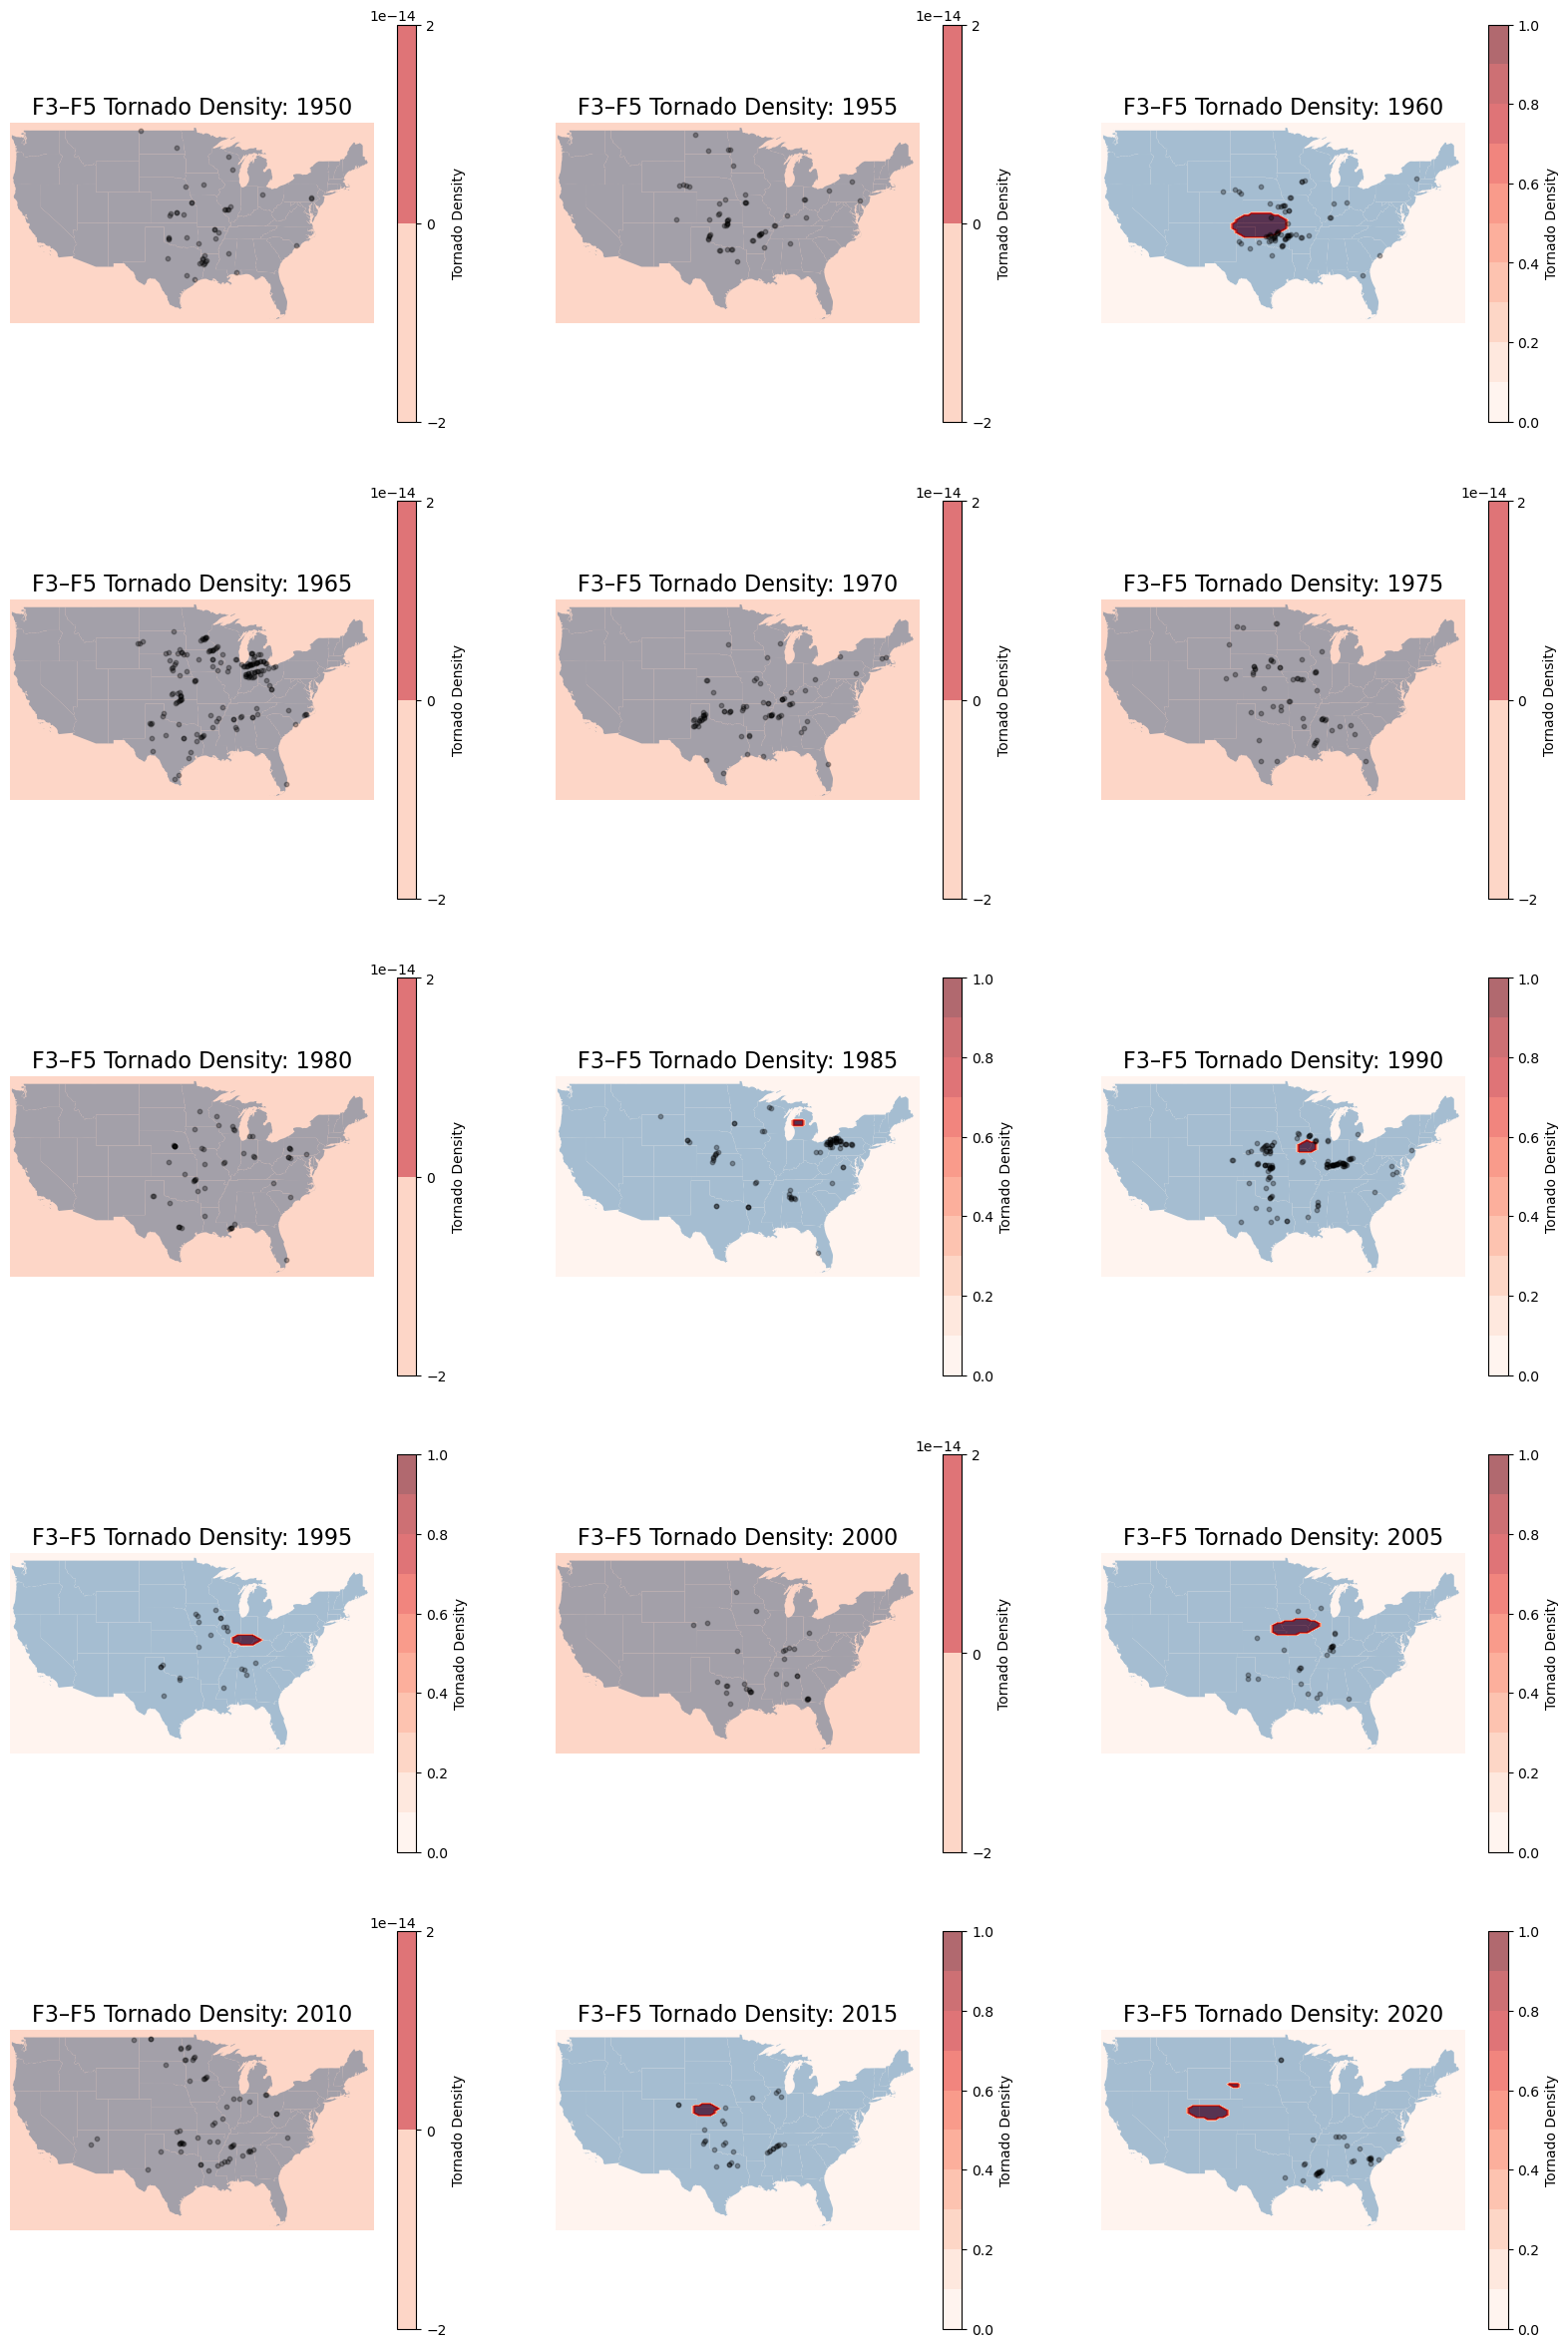

In [123]:
 ## This code block draws a contour plot of the mollified empirical distribution for some selected years, for visualization's sake.

years = np.arange(1950,2025,5)

fig, axs = plt.subplots(5,3)
fig.set_size_inches(20,30)

xmin, xmax = -125, -66
ymin, ymax = 24, 50

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

for year in years:
    plot_x = ((year - 1950) // 5) % 3
    plot_y = ((year - 1950) // 5) // 3

    density = tornado_kdes[year](positions).reshape(xx.shape)
    tornado_alley = np.stack(np.vectorize(lambda x: int(x > REQUIRED_FREQ))(density),axis=1)

    ax = axs[plot_y,plot_x]
    states.plot(ax=ax)

    contour = ax.contourf(xx, yy, tornado_alley, levels=10, cmap='Reds', alpha=0.6)
    plt.colorbar(contour, ax=ax, label='Tornado Density')

    tornado_x = tornado_df[tornado_df['year']==year]['begin_lon'].values
    tornado_y = tornado_df[tornado_df['year']==year]['begin_lat'].values
    ax.scatter(tornado_x, tornado_y, c='black', s=10, alpha=0.3)

    ax.set_title("F3–F5 Tornado Density: " + str(year), fontsize=16)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_axis_off()

## The Climate Data

In [109]:
climate_df = pd.read_csv('yearly_climate_data.csv')

climate_df

,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,CDSD,CLDD,DP01,DP10,DP1X,...,TAVG,TMAX,TMIN,DSND,DSNW,EMSD,EMSN,SNOW,DYFG,DYTS
0,2009,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",184.3,184.3,115.0,54.0,1.0,...,6.26,12.07,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",344.1,344.1,95.0,61.0,7.0,...,7.32,12.91,1.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",370.3,370.3,98.0,52.0,5.0,...,7.12,13.00,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",538.1,538.1,NaN,NaN,NaN,...,9.75,16.33,3.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",366.8,366.8,120.0,41.0,3.0,...,6.34,12.06,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689112,2020,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",598.1,598.1,84.0,53.0,4.0,...,11.14,17.23,5.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689113,2021,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",668.7,668.7,73.0,45.0,11.0,...,11.71,17.83,5.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689114,2022,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",724.6,724.6,73.0,40.0,6.0,...,11.04,18.11,3.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689115,2023,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",662.8,662.8,79.0,49.0,6.0,...,11.93,18.53,5.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN


First, we need to attach ground truth to our dataframe. We'll create a new column, assigning a value of 1 if the corresponding point lies within Tornado Alley, and a value of 0 otherwise.

In [116]:
def tornado_alley_classification(lat,lon,year):
    '''
        Given floats lat and lon representing the latitude and longitude of a point and an int year representing the year,
        outputs 1 if the point falls within tornado alley and a 0 otherwise.
    '''
    return int(tornado_kdes[year]([lon,lat])[0] > REQUIRED_FREQ)

def tornado_alley_calc(row):
    return tornado_alley_classification(row['LATITUDE'],row['LONGITUDE'],row['DATE'])

climate_df['tornado_alley'] = climate_df.apply(tornado_alley_calc, axis=1)

climate_df

,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,CDSD,CLDD,DP01,DP10,DP1X,...,TMAX,TMIN,DSND,DSNW,EMSD,EMSN,SNOW,DYFG,DYTS,tornado_alley
0,2009,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",184.3,184.3,115.0,54.0,1.0,...,12.07,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2010,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",344.1,344.1,95.0,61.0,7.0,...,12.91,1.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2011,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",370.3,370.3,98.0,52.0,5.0,...,13.00,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2012,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",538.1,538.1,NaN,NaN,NaN,...,16.33,3.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2013,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",366.8,366.8,120.0,41.0,3.0,...,12.06,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689112,2020,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",598.1,598.1,84.0,53.0,4.0,...,17.23,5.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
689113,2021,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",668.7,668.7,73.0,45.0,11.0,...,17.83,5.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
689114,2022,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",724.6,724.6,73.0,40.0,6.0,...,18.11,3.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
689115,2023,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",662.8,662.8,79.0,49.0,6.0,...,18.53,5.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [117]:
climate_df[climate_df['tornado_alley'] == 1]

,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,CDSD,CLDD,DP01,DP10,DP1X,...,TMAX,TMIN,DSND,DSNW,EMSD,EMSN,SNOW,DYFG,DYTS,tornado_alley
3936,2011,33.80290,-86.56010,326.1,"SPRINGVILLE 5.3 WNW, AL US",NaN,NaN,104.0,65.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3947,2011,34.09130,-86.60660,215.2,"BLOUNTSVILLE 1.3 NW, AL US",NaN,NaN,113.0,77.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3954,2011,33.94163,-86.45551,282.9,"ONEONTA 0.9 SE, AL US",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3956,2011,33.91530,-86.34640,419.4,"ONEONTA 7.5 ESE, AL US",NaN,NaN,111.0,68.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4133,2011,32.81610,-85.17330,170.4,"VALLEY 0.5 N, AL US",NaN,NaN,45.0,44.0,14.0,...,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683366,2021,36.12528,-90.92444,83.2,"WALNUT RIDGE MUNICIPAL AIRPORT, AR US",1003.4,1003.4,NaN,NaN,NaN,...,21.14,10.27,NaN,NaN,NaN,NaN,NaN,143.0,29.0,1
683402,1982,33.22072,-92.81404,78.0,"EL DORADO GOODWIN FIELD, AR US",NaN,NaN,117.0,76.0,26.0,...,NaN,NaN,2.0,2.0,51.0,51.0,79.0,NaN,NaN,1
683419,1999,33.22072,-92.81404,78.0,"EL DORADO GOODWIN FIELD, AR US",1279.4,1279.4,89.0,60.0,12.0,...,25.82,11.15,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1
683469,1982,36.01027,-94.16824,377.1,"FAYETTEVILLE DRAKE FIELD, AR US",801.1,801.1,101.0,74.0,16.0,...,20.36,8.05,12.0,3.0,76.0,76.0,203.0,14.0,1.0,1


We'll need to separate our data for training and testing our model. This is made somewhat tricky by the fact that most (almost all) weather stations do not report values for all of our attributes, so that values of attributes will need to be determined by interpolation. As such, we'll be doing the following:
* The years 1980-1989 and 2020-2024, inclusive, are to be designated as testing years. All data from these years will be set aside.
* Of the remaining data, a random 20% from each year will be set aside as a further testing set.
* We'll perform cross-validation on the data which remains. The data will be divided so as to ensure that no year has so much data removed from it so as to render interpolation inaccurate.

In [165]:
from scipy.interpolate import LinearNDInterpolator

def linear_feature_interpolator(data,lat_feature,lon_feature,interp_feature:str):
    """
        Given a dataframe data, performs linear interpolation of the feature named interp_feature (a string). 
            lat_feature and lon_feature are strings giving the name of the features describing latitude and longitude.

            Values of interp_feature which are not NaN are associated with the corresponding latitude and longitude, and interpolation connects these values.
    
        Outputs a dataframe with the same size and contents as data, except in the feature interp_feature, 
        any values which are presently NaN are replaced with the value obtained from the interpolation procedure.
    """
    non_NaN_data = data[[lat_feature,lon_feature,interp_feature]][~data[interp_feature].isna()]
    interp = LinearNDInterpolator(non_NaN_data[[lat_feature,lon_feature]],non_NaN_data[interp_feature])

    data.loc[:,interp_feature] = interp(data[lat_feature],data[lon_feature])

    return data

def linear_multiple_feature_interpolator(data,lat_feature,lon_feature,interp_features:list):
    '''
         Interpolates the values separately for each feature in interp_features, one at a time.
    '''
    for feature in interp_features:
        data = linear_feature_interpolator(data,lat_feature,lon_feature,feature)

    return data

def multiyear_linear_feature_interpolator(data,lat_feature,lon_feature,interp_features:list,year_feature, years:list):
    '''
        Interpolates the values for each feature in interp_features, for each year in years.
        year_feature is a string giving the label of the column of data in which the year is stored.
    '''

    for year in years:
        year_df = data[data[year_feature] == year]
        year_df = linear_multiple_feature_interpolator(year_df,lat_feature,lon_feature,interp_features)
    
        data.loc[year_df.index] = year_df

        print(str(year) + ' completed')
    
    return data
    


In [73]:
features_to_interpolate = climate_df.columns[5:]
redundant_features = ['CDSD','HDSD','TAVG']
special_attributes = ['EMNT', 'EMXP', 'EMXT', 'EMSD', 'EMSN'] # The attributes for these features have extra, and potentially useful, information that we would need to handle with some care
date_features = ['FZF0', 'FZF1', 'FZF2', 'FZF3', 'FZF4', 'FZF5', 'FZF6', 'FZF7', 'FZF8', 'FZF9'] # The values for these features are dates, so we would need to handle them separately
features_to_interpolate = features_to_interpolate.drop(redundant_features)
features_to_interpolate = features_to_interpolate.drop(special_attributes)
features_to_interpolate = features_to_interpolate.drop(date_features)

features_to_interpolate = list(features_to_interpolate)
features_to_interpolate

['CLDD',
 'DP01',
 'DP10',
 'DP1X',
 'DT00',
 'DT32',
 'DX32',
 'DX70',
 'DX90',
 'HTDD',
 'PRCP',
 'TMAX',
 'TMIN',
 'DSND',
 'DSNW',
 'SNOW',
 'DYFG',
 'DYTS']

### The 'Specific Years' Testing Data

In [141]:
test_years = list(range(1980,1990)) + list(range(2020,2025))
test_year_df = climate_df[climate_df['DATE'].isin(test_years)]
test_year_df = pd.concat([test_year_df[['DATE','LATITUDE','LONGITUDE','ELEVATION','NAME','tornado_alley']],test_year_df[features_to_interpolate]],axis=1)

test_year_df = multiyear_linear_feature_interpolator(test_year_df, 'LATITUDE','LONGITUDE', features_to_interpolate,'DATE',test_years)

for feature in features_to_interpolate:
    test_year_df = test_year_df[~test_year_df[feature].isnull()]

test_year_df = test_year_df.reset_index(drop=True)

test_year_df

1980 completed
1981 completed
1982 completed
1983 completed
1984 completed
1985 completed
1986 completed
1987 completed
1988 completed
1989 completed
2020 completed
2021 completed
2022 completed
2023 completed
2024 completed


,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,tornado_alley,CLDD,DP01,DP10,DP1X,...,DX90,HTDD,PRCP,TMAX,TMIN,DSND,DSNW,SNOW,DYFG,DYTS
0,2020,40.5093,-98.5493,601.1,"JUNIATA 6.0 SSW, NE US",0,673.022423,79.0,40.0,5.0,...,49.652941,3278.078747,473.6,18.045637,4.993178,35.892998,10.167193,629.833025,82.812037,25.809778
1,2021,40.5093,-98.5493,601.1,"JUNIATA 6.0 SSW, NE US",0,661.494318,74.0,45.0,4.0,...,38.271164,3311.985823,646.8,17.838355,4.951377,37.211041,10.278738,713.001772,100.073340,26.667885
2,2020,40.4798,-98.4026,570.0,"AYR 3.5 NE, NE US",0,687.358550,79.0,39.0,3.0,...,50.535723,3271.167155,491.8,18.173921,5.242107,34.022392,9.135612,569.032228,91.095913,25.895690
3,2021,40.4798,-98.4026,570.0,"AYR 3.5 NE, NE US",0,682.902632,77.0,47.0,4.0,...,42.433378,3301.167124,688.9,18.037686,4.953998,35.967570,8.180132,658.963355,110.925692,22.531353
4,2020,40.4953,-98.2973,566.9,"GLENVIL 2.3 WSW, NE US",0,666.888251,72.0,31.0,3.0,...,46.622199,3281.711222,435.3,17.992239,5.199355,34.605643,9.648660,578.529113,73.649213,20.890412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141950,2020,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",0,598.100000,84.0,53.0,4.0,...,20.000000,3273.985686,686.0,17.230000,5.040000,36.304437,11.311418,708.395364,69.526786,36.688967
141951,2021,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",0,668.700000,73.0,45.0,11.0,...,33.000000,3304.900000,792.6,17.830000,5.580000,41.267275,8.655709,839.814951,72.985282,29.179768
141952,2022,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",0,724.600000,73.0,40.0,6.0,...,50.000000,3036.800000,493.3,18.110000,3.980000,13.967127,3.058600,189.364304,38.832051,31.360645
141953,2023,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",0,662.800000,79.0,49.0,6.0,...,32.000000,3237.800000,611.5,18.530000,5.330000,19.875558,5.118656,496.002090,72.470351,38.195966


In [142]:
data_per_year = [[year, test_year_df[test_year_df['DATE'] == year].shape[0]] for year in test_years]
data_per_year = sorted(data_per_year, key = lambda x: x[1])

print(data_per_year)


[[1980, 7033], [1985, 7411], [1988, 7445], [1986, 7468], [1987, 7479], [1982, 7495], [1981, 7501], [1984, 7513], [1983, 7565], [1989, 7705], [2024, 13065], [2021, 13477], [2022, 13511], [2023, 13568], [2020, 13719]]


### The 'Randomly Selected' Testing Data

In [143]:
non_test_years = list(range(1950,1980)) + list(range(1990,2020))
remaining_df = climate_df[climate_df['DATE'].isin(non_test_years)]

remaining_df

,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,CDSD,CLDD,DP01,DP10,DP1X,...,TMAX,TMIN,DSND,DSNW,EMSD,EMSN,SNOW,DYFG,DYTS,tornado_alley
0,2009,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",184.3,184.3,115.0,54.0,1.0,...,12.07,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2010,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",344.1,344.1,95.0,61.0,7.0,...,12.91,1.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2011,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",370.3,370.3,98.0,52.0,5.0,...,13.00,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2012,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",538.1,538.1,NaN,NaN,NaN,...,16.33,3.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2013,43.7333,-96.6333,482.0,"SIOUX FALLS ENVIRON. CANADA, SD US",366.8,366.8,120.0,41.0,3.0,...,12.06,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689107,2015,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",571.7,571.7,109.0,67.0,10.0,...,17.67,5.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
689108,2016,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",654.1,654.1,87.0,52.0,9.0,...,18.36,6.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
689109,2017,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",579.4,579.4,84.0,57.0,9.0,...,17.98,5.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
689110,2018,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",651.0,651.0,103.0,66.0,9.0,...,16.17,4.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [153]:
from sklearn.model_selection import train_test_split

random_state = 175

yearly_test_data = []
yearly_train_data = []
for year in non_test_years:
    year_df = remaining_df[remaining_df['DATE'] == year]
    train, test = train_test_split(year_df, test_size=.2, random_state=year*random_state)
    yearly_train_data.append(train)
    yearly_test_data.append(test)

test_rand_df = pd.concat(yearly_test_data)
test_rand_df = pd.concat([test_rand_df[['DATE','LATITUDE','LONGITUDE','ELEVATION','NAME','tornado_alley']],test_rand_df[features_to_interpolate]],axis=1)

remaining_df = pd.concat(yearly_train_data)
remaining_df = pd.concat([remaining_df[['DATE','LATITUDE','LONGITUDE','ELEVATION','NAME','tornado_alley']],remaining_df[features_to_interpolate]],axis=1)

In [154]:
data_per_year = [[year, test_rand_df[test_rand_df['DATE'] == year].shape[0]] for year in non_test_years]
data_per_year = sorted(data_per_year, key = lambda x: x[1])

print(data_per_year)

[[1978, 1144], [1979, 1150], [1973, 1156], [1977, 1162], [1976, 1186], [1975, 1191], [1974, 1210], [1972, 1237], [1993, 1241], [1990, 1252], [1971, 1268], [1991, 1274], [1968, 1276], [1995, 1280], [1992, 1282], [1994, 1292], [1996, 1294], [1970, 1295], [1964, 1303], [1969, 1306], [1965, 1307], [1997, 1316], [1966, 1324], [1967, 1324], [1998, 1348], [1962, 1350], [1963, 1353], [1951, 1364], [1955, 1376], [1999, 1377], [1954, 1382], [2000, 1383], [1952, 1385], [1961, 1385], [1953, 1389], [1960, 1389], [2001, 1391], [1950, 1394], [1958, 1396], [1956, 1397], [1959, 1401], [1957, 1409], [2002, 1413], [2003, 1449], [2004, 1458], [2005, 1480], [2006, 1537], [2007, 1596], [2008, 1712], [2009, 1799], [2010, 1941], [2011, 1945], [2015, 1959], [2013, 1970], [2016, 1973], [2014, 1984], [2012, 1985], [2017, 1998], [2018, 2031], [2019, 2053]]


We'll now apply the same interpolation scheme to this test set. 
There is some reasonable worry to be had here about the mesh of the interpolation.

In [166]:
test_rand_df = multiyear_linear_feature_interpolator(test_rand_df, 'LATITUDE','LONGITUDE', features_to_interpolate,'DATE',non_test_years)

for feature in features_to_interpolate:
    test_rand_df = test_rand_df[~test_rand_df[feature].isna()]

test_rand_df = test_rand_df.reset_index(drop=True)

test_year_df

1950 completed
1951 completed
1952 completed
1953 completed
1954 completed
1955 completed
1956 completed
1957 completed
1958 completed
1959 completed
1960 completed
1961 completed
1962 completed
1963 completed
1964 completed
1965 completed
1966 completed
1967 completed
1968 completed
1969 completed
1970 completed
1971 completed
1972 completed
1973 completed
1974 completed
1975 completed
1976 completed
1977 completed
1978 completed
1979 completed
1990 completed
1991 completed
1992 completed
1993 completed
1994 completed
1995 completed
1996 completed
1997 completed
1998 completed
1999 completed
2000 completed
2001 completed
2002 completed
2003 completed
2004 completed
2005 completed
2006 completed
2007 completed
2008 completed
2009 completed
2010 completed
2011 completed
2012 completed
2013 completed
2014 completed
2015 completed
2016 completed
2017 completed
2018 completed
2019 completed


,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,tornado_alley,CLDD,DP01,DP10,DP1X,...,DX90,HTDD,PRCP,TMAX,TMIN,DSND,DSNW,SNOW,DYFG,DYTS
0,2020,40.5093,-98.5493,601.1,"JUNIATA 6.0 SSW, NE US",0,673.022423,79.0,40.0,5.0,...,49.652941,3278.078747,473.6,18.045637,4.993178,35.892998,10.167193,629.833025,82.812037,25.809778
1,2021,40.5093,-98.5493,601.1,"JUNIATA 6.0 SSW, NE US",0,661.494318,74.0,45.0,4.0,...,38.271164,3311.985823,646.8,17.838355,4.951377,37.211041,10.278738,713.001772,100.073340,26.667885
2,2020,40.4798,-98.4026,570.0,"AYR 3.5 NE, NE US",0,687.358550,79.0,39.0,3.0,...,50.535723,3271.167155,491.8,18.173921,5.242107,34.022392,9.135612,569.032228,91.095913,25.895690
3,2021,40.4798,-98.4026,570.0,"AYR 3.5 NE, NE US",0,682.902632,77.0,47.0,4.0,...,42.433378,3301.167124,688.9,18.037686,4.953998,35.967570,8.180132,658.963355,110.925692,22.531353
4,2020,40.4953,-98.2973,566.9,"GLENVIL 2.3 WSW, NE US",0,666.888251,72.0,31.0,3.0,...,46.622199,3281.711222,435.3,17.992239,5.199355,34.605643,9.648660,578.529113,73.649213,20.890412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141950,2020,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",0,598.100000,84.0,53.0,4.0,...,20.000000,3273.985686,686.0,17.230000,5.040000,36.304437,11.311418,708.395364,69.526786,36.688967
141951,2021,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",0,668.700000,73.0,45.0,11.0,...,33.000000,3304.900000,792.6,17.830000,5.580000,41.267275,8.655709,839.814951,72.985282,29.179768
141952,2022,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",0,724.600000,73.0,40.0,6.0,...,50.000000,3036.800000,493.3,18.110000,3.980000,13.967127,3.058600,189.364304,38.832051,31.360645
141953,2023,40.6954,-96.8541,418.2,"LINCOLN 11 SW, NE US",0,662.800000,79.0,49.0,6.0,...,32.000000,3237.800000,611.5,18.530000,5.330000,19.875558,5.118656,496.002090,72.470351,38.195966


The data here is fairly sparse, but perhaps >20 datapoints per state is sufficient, provided the points have a reasonable spread across the country.

Notice that, due to intricacies of the interpolation method, points near the boundary of the US are somewhat likely to be lost during interpolation. Given that Tornado Alley is somewhat inland, this is unlikely to cause any severe issues.

In [167]:
data_per_year = [[year, test_rand_df[test_rand_df['DATE'] == year].shape[0]] for year in non_test_years]
data_per_year = sorted(data_per_year, key = lambda x: x[1])

print(data_per_year)

[[1977, 987], [1979, 999], [1978, 1011], [1973, 1052], [1974, 1097], [1975, 1097], [1976, 1104], [1972, 1136], [1971, 1145], [1998, 1180], [1993, 1193], [1965, 1198], [1970, 1206], [1967, 1207], [1990, 1212], [1968, 1214], [1969, 1238], [1994, 1240], [1995, 1245], [1964, 1246], [1991, 1247], [1966, 1251], [1992, 1252], [1996, 1259], [1997, 1266], [1963, 1323], [1962, 1324], [1951, 1331], [1999, 1334], [2001, 1335], [2000, 1338], [1950, 1345], [1954, 1353], [1955, 1353], [1960, 1354], [1961, 1354], [1953, 1356], [2002, 1361], [1952, 1364], [1956, 1365], [1958, 1371], [1959, 1374], [2004, 1390], [1957, 1396], [2003, 1398], [2005, 1429], [2006, 1484], [2007, 1538], [2008, 1660], [2009, 1681], [2011, 1735], [2014, 1807], [2013, 1821], [2012, 1839], [2015, 1843], [2017, 1843], [2019, 1862], [2018, 1866], [2016, 1870], [2010, 1895]]


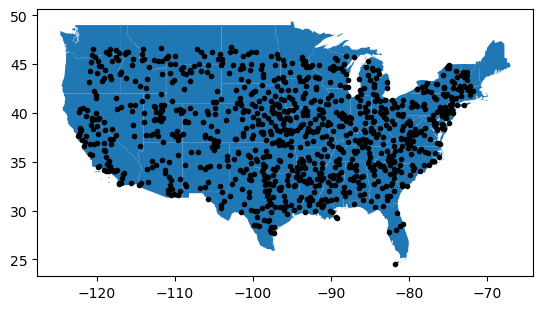

In [170]:
states.plot()

smallest_year = test_rand_df[test_rand_df['DATE'] == data_per_year[0][0]]
plt.scatter(smallest_year['LONGITUDE'],smallest_year['LATITUDE'],c='black',marker='.')
plt.show()

### Setting up Cross Validation Sets for the Remaining Data

We'd like to set up cross-validation with the remaining data. Given our experience with taking the 20% of random data in the previous stage, we believe that using more than 4 splits at present would cause the mesh of the interpolation grid to become unreasonably large.

In [172]:
from sklearn.model_selection import KFold

num_sets = 4
random_state = 281
kfold = KFold(n_splits=4,shuffle=True,random_state=582)

cross_df = kfold.split(remaining_df)